In [1]:
import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.plr_ash import PenalizedMrASH

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    #prior_grid = (np.arange(k) * 5) + 0.1
    #prior_grid *= scale
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [2]:
def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, intercept = 0):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    plt.tight_layout()
    plt.show()

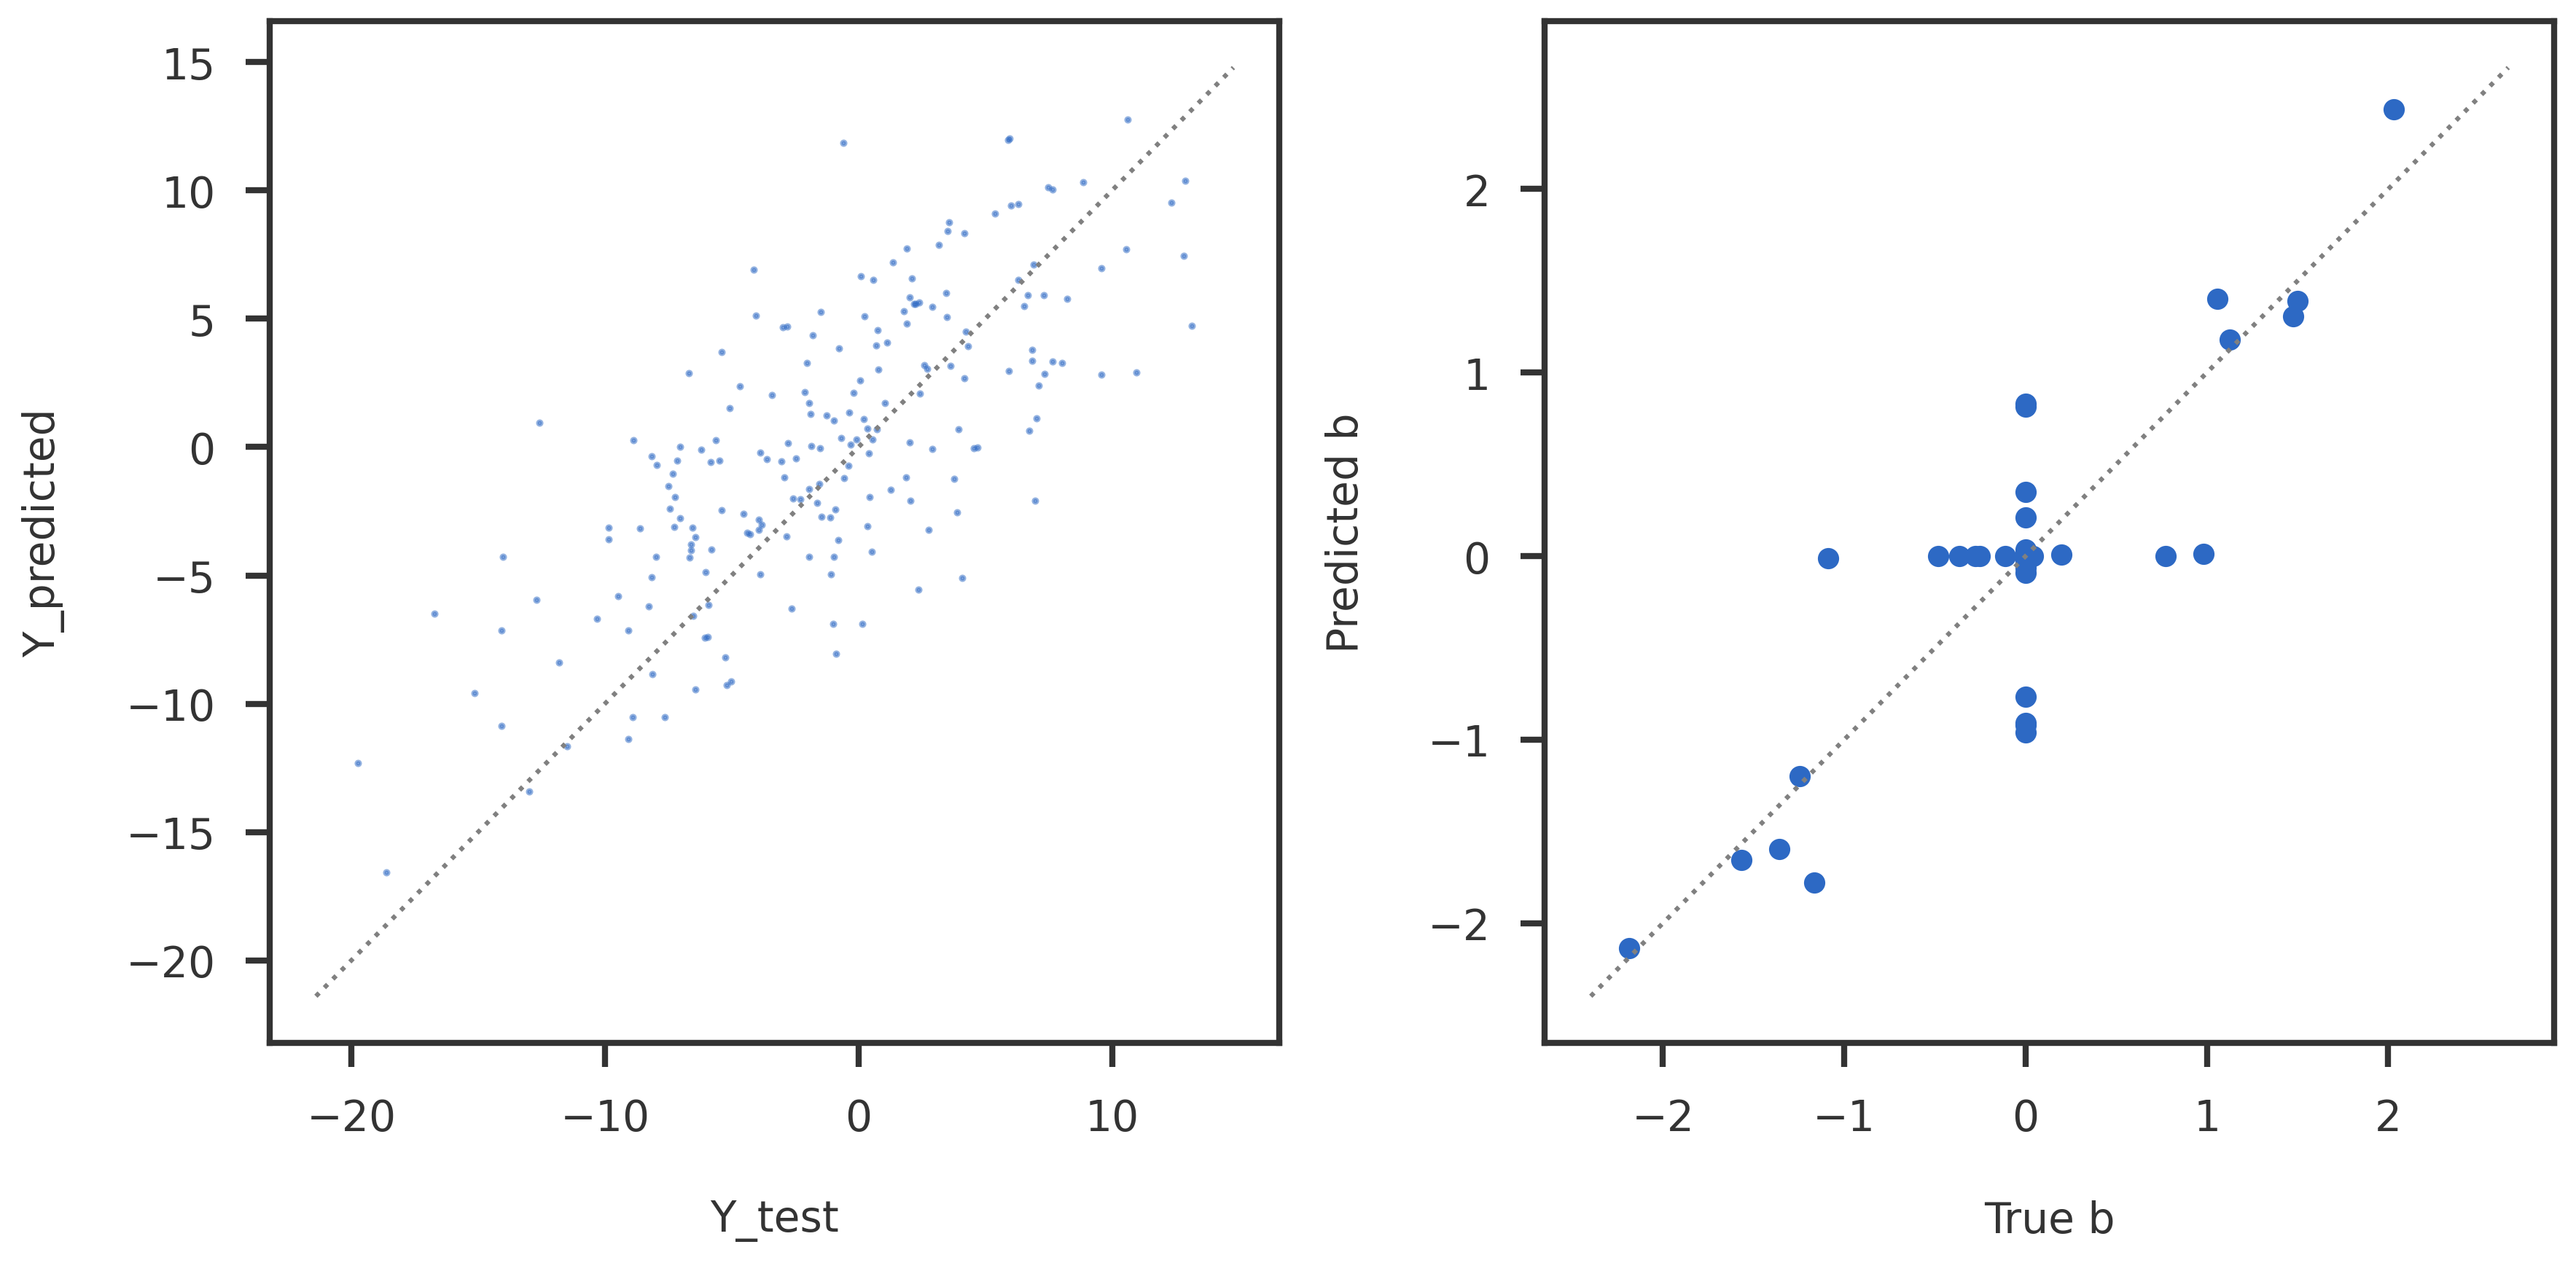

In [11]:
n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept)

In [12]:
plr_lbfgs.residual_var

8.806995552079036

In [13]:
plr_lbfgs.prior

array([9.88150924e-01, 4.99782971e-12, 4.99782971e-12, 4.99782971e-12,
       4.99782971e-12, 4.99782971e-12, 4.99782971e-12, 4.99782971e-12,
       4.99782971e-12, 2.90533365e-03, 8.17653187e-03, 7.67210030e-04,
       4.99782971e-12, 4.99782971e-12, 4.99782971e-12, 4.99782971e-12,
       4.99782971e-12, 4.99782971e-12, 4.99782971e-12, 4.99782971e-12])

In [14]:
strue * strue

12.344883118460732

/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/mr-ash-pen/src/mrashpen/inference/mrash_wrapR.py
Mr.ASH terminated at iteration 23.


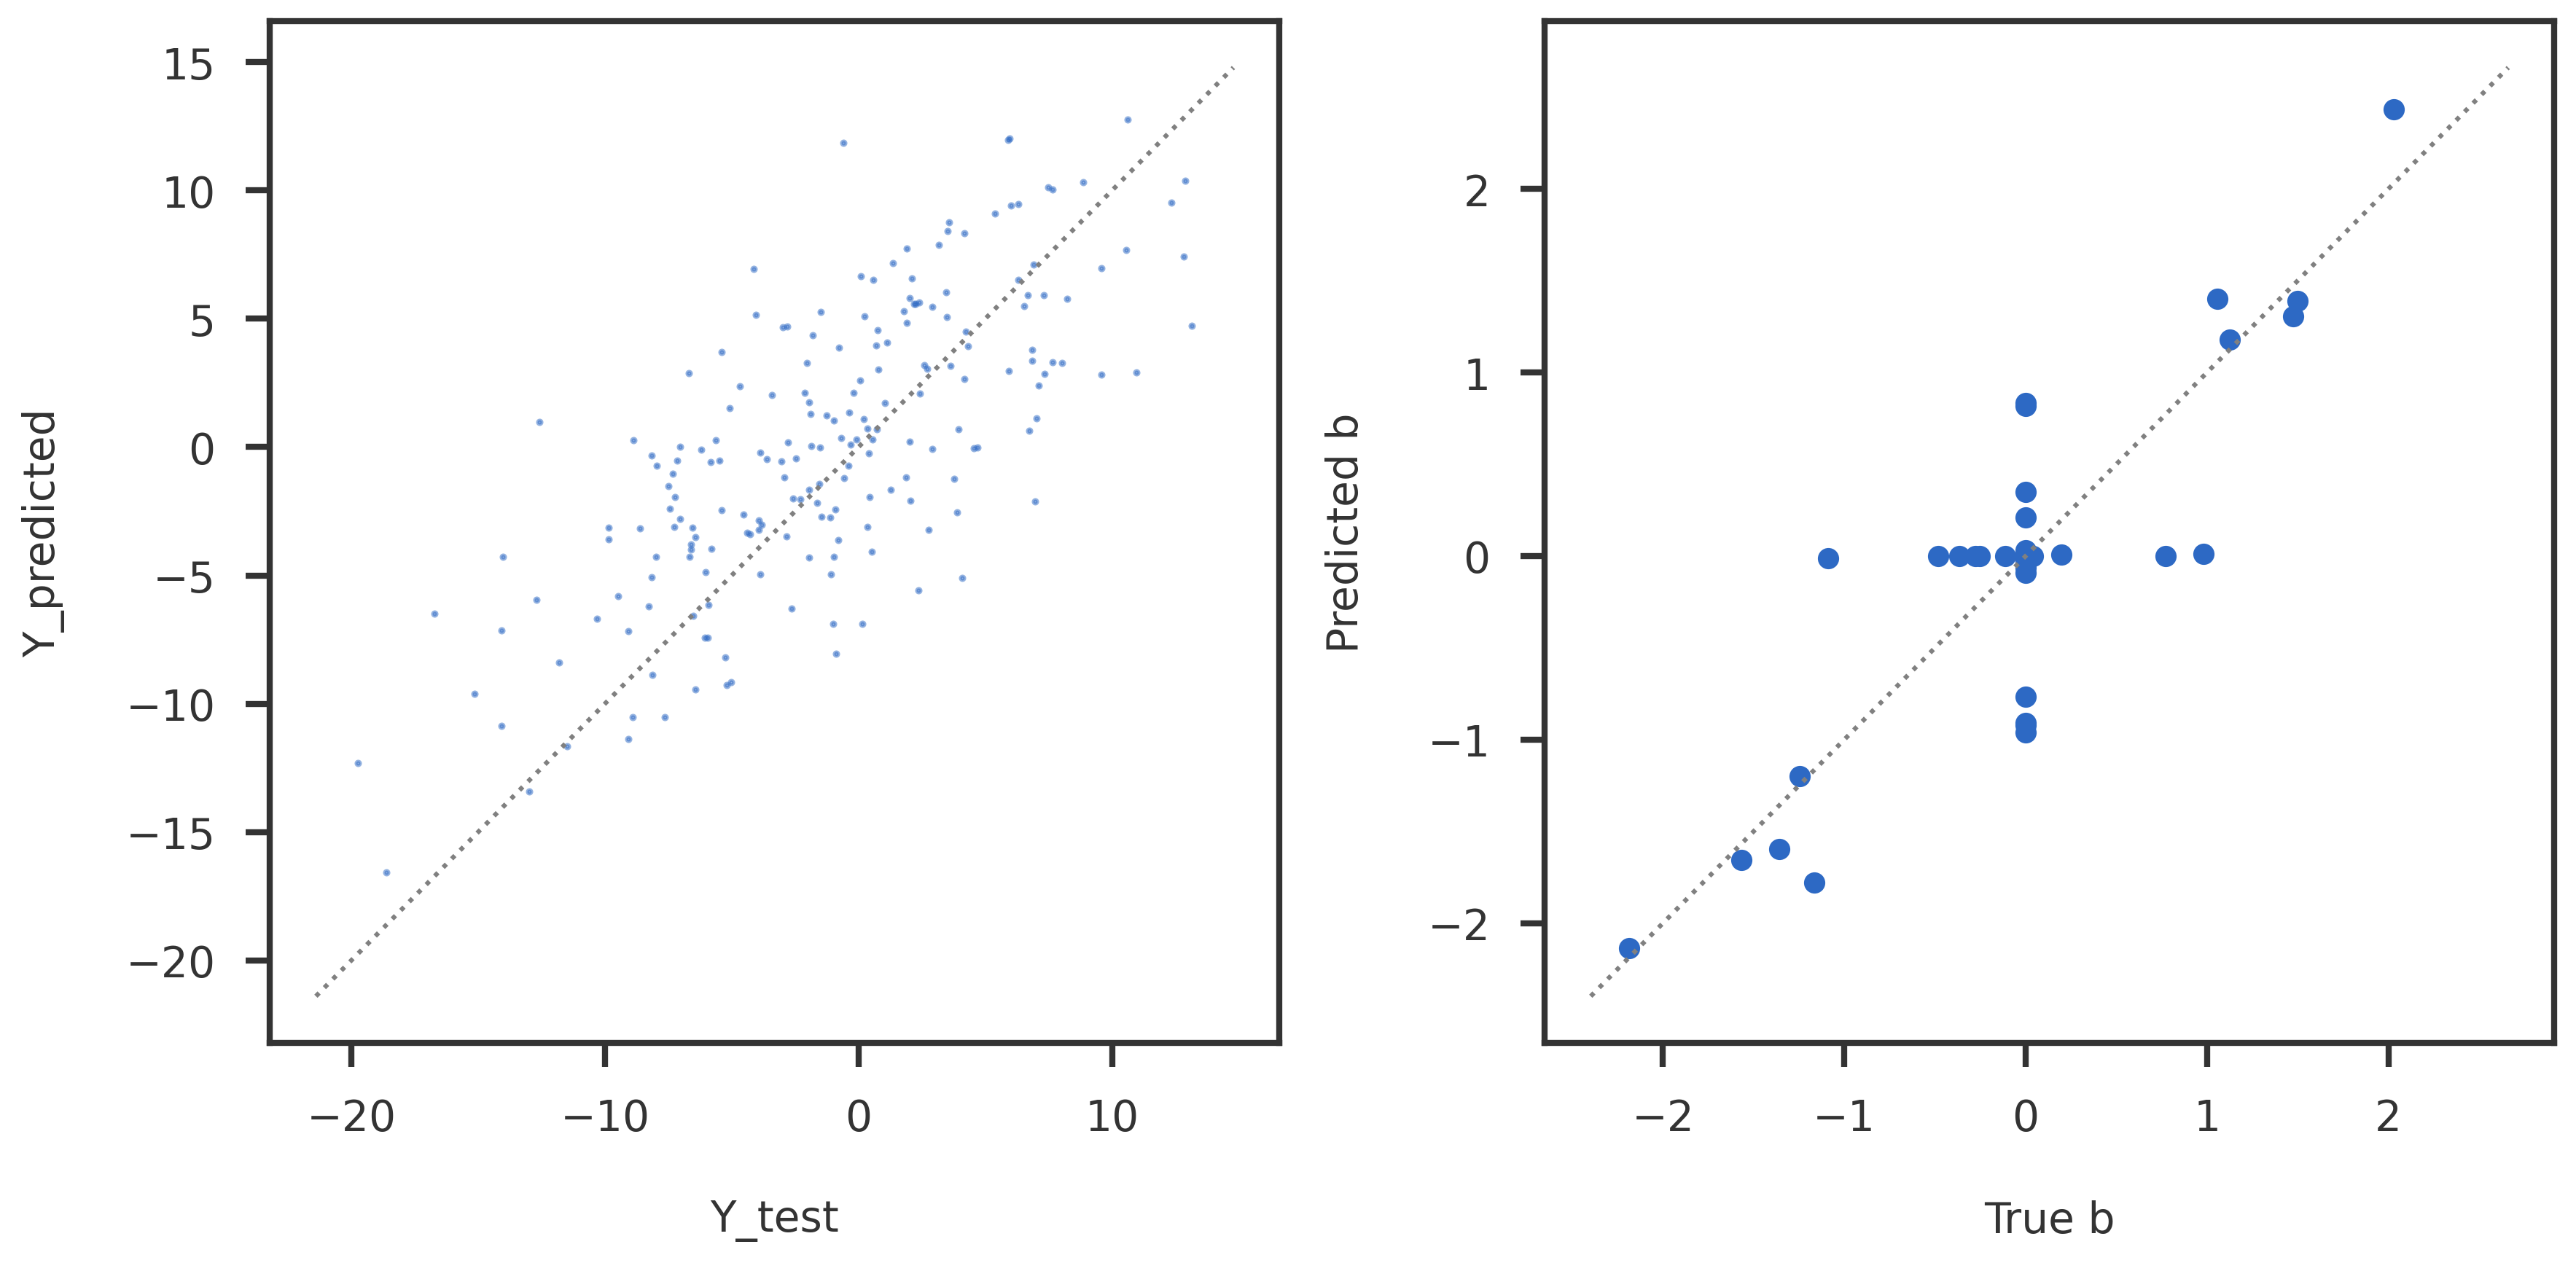

In [15]:
## Mr.ASH.alpha on optimized result
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, 
            binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, mrash_r.coef, intercept = mrash_r.intercept)

/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/mr-ash-pen/src/mrashpen/inference/mrash_wrapR.py
2021-09-12 16:36:45,217 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 23.

2021-09-12 16:36:45,218 | mrashpen.inference.mrash_wrapR | DEBUG | ERROR ==>
2021-09-12 16:36:45,218 | mrashpen.inference.mrash_wrapR | DEBUG | Warning message:
In mr.ash.alpha::mr.ash(as.matrix(data$X), as.vector(data$y), max.iter = opt$maxiter,  :
  The mixture proportion associated with the largest prior variance is greater than zero; this indicates that the model fit could be improved by using a larger setting of the prior variance. Consider increasing the range of the variances "sa2".



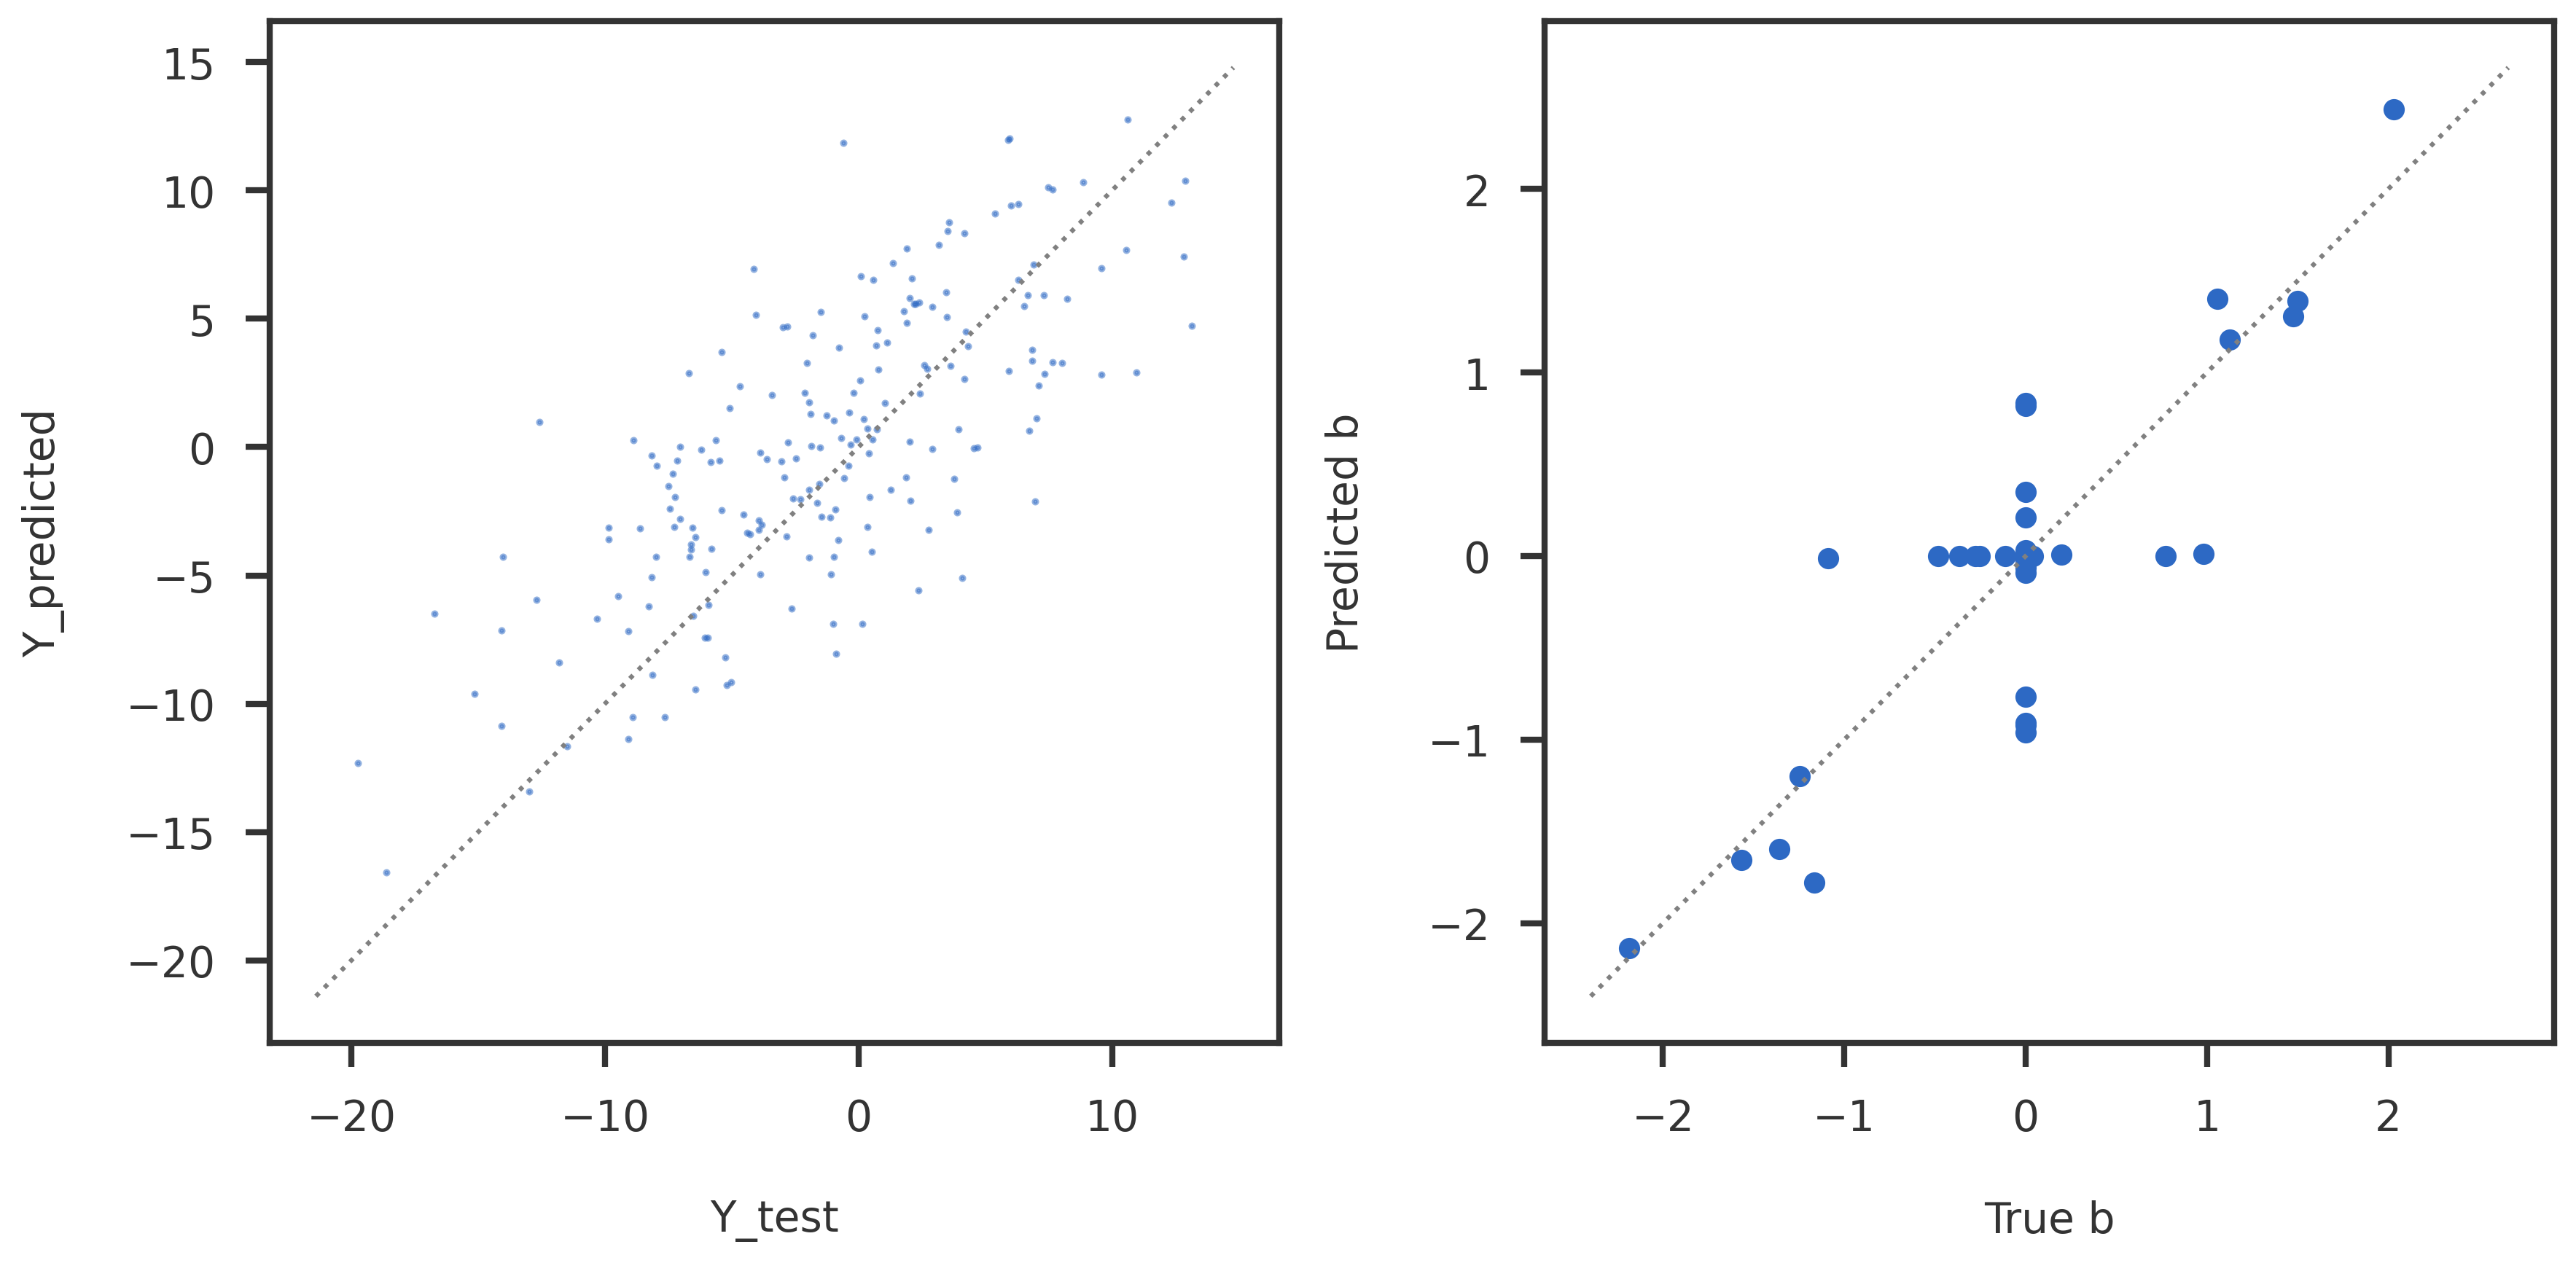

In [16]:
## Optimize
mrash_rds = MrASHR(option = "rds", debug = True)
mrash_rds.fit(X, y, sk, 
              binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var, 
              maxiter = 2000)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, mrash_rds.coef, intercept = mrash_rds.intercept)